# Automated doubly robust estimation with ChiRho

In [1]:
import collections
import math
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Dict

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal
from pyro.infer import Predictive
from typing import Callable, Dict, List, Optional, Tuple, Union

from chirho.observational.handlers import condition
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather

pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

# Probabilistic model for the data generating process

In [2]:
gaussian_link = lambda mu: dist.Normal(mu, 1.)
bernoulli_link = lambda mu: dist.Bernoulli(logits=mu)

class HighDimLinearModel(pyro.nn.PyroModule):
    def __init__(
        self, p: int, link_fn: Callable[..., dist.Distribution] = gaussian_link
    ):
        super().__init__()
        self.p = p
        self.link_fn = link_fn

    def sample_outcome_weights(self):
        return pyro.sample(
            "outcome_weights",
            dist.Normal(0.0, 1.0 / math.sqrt(self.p)).expand((self.p,)).to_event(1),
        )

    def sample_intercept(self):
        return pyro.sample("intercept", dist.Normal(0.0, 1.0))

    def sample_propensity_weights(self):
        return pyro.sample(
            "propensity_weights",
            dist.Normal(0.0, 1.0 / math.sqrt(self.p)).expand((self.p,)).to_event(1),
        )

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0.0, 1.0))

    def sample_covariate_loc_scale(self):
        loc = pyro.sample(
            "covariate_loc", dist.Normal(0.0, 1.0).expand((self.p,)).to_event(1)
        )
        scale = pyro.sample(
            "covariate_scale", dist.LogNormal(0, 1).expand((self.p,)).to_event(1)
        )
        return loc, scale

    def forward(self, N: int):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        with pyro.plate("obs", N, dim=-1):
            X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1))
            A = pyro.sample(
                "A",
                dist.Bernoulli(
                    logits=torch.einsum("...np,...p->...n", X, propensity_weights)
                ),
            )
            return pyro.sample(
                "Y",
                self.link_fn(
                    torch.einsum("...np,...p->...n", X, outcome_weights)
                    + A * tau
                    + intercept
                ),
            )


class KnownCovariateDistModel(HighDimLinearModel):
    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)


class BenchmarkLinearModel(HighDimLinearModel):
    def __init__(
        self,
        p: int,
        link_fn: Callable,
        alpha: int,
        beta: int,
        treatment_weight: float = 0.0,
    ):
        super().__init__(p, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparisty of outcome weights
        self.treatment_weight = treatment_weight

    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta :] = 0.0
        return outcome_weights

    def sample_treatment_null_weight(self):
        return torch.tensor(0.0)

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(4 * self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha :] = 0.0
        return propensity_weights

    def sample_treatment_weight(self):
        return torch.tensor(self.treatment_weight)

    def sample_treatment_null_weight(self):
        return torch.tensor(0.0)

    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)


class ConditionedModel(KnownCovariateDistModel):
    def forward(self, D):
        with condition(data=D):
            # Assume first dimension corresponds to # of datapoints
            N = D[next(iter(D))].shape[0]
            return super().forward(N=N)

# Functional of interest

In [3]:
def ATE(model: Callable[[], torch.Tensor], num_samples: int = 100) -> torch.Tensor:
    """Compute the average treatment effect of a model."""
    with MultiWorldCounterfactual():
        with do(actions=dict(A=(torch.tensor(0.0), torch.tensor(1.0)))):
            Ys = model(N=num_samples)
        Y0 = gather(Ys, IndexSet(A={1}), event_dim=0)
        Y1 = gather(Ys, IndexSet(A={2}), event_dim=0)
    return pyro.deterministic("ATE", (Y1 - Y0).mean(dim=-1, keepdim=True).squeeze())

# Automated influence function

In [4]:
def flatten_dict(d: Dict[str, torch.tensor]) -> torch.tensor:
    """
    Flatten a dictionary of tensors into a single vector.
    """
    return torch.cat([v.flatten() for k, v in d.items()])


def unflatten_dict(x: torch.tensor, d: Dict[str, torch.tensor]) -> Dict[str, torch.tensor]:
    """
    Unflatten a vector into a dictionary of tensors.
    """
    return collections.OrderedDict(zip(
        d.keys(), [v_flat.reshape(v.shape) for v, v_flat in zip(d.values(), torch.split(x, [v.numel() for k, v in d.items()]))]
    ))


# TODO: change so that only need model
def monte_carlo_fisher_info_of_model(
    unconditioned_model: Callable[[], torch.tensor],  # simulates data
    conditioned_model: Callable[[], torch.tensor],  # computes log likelihood
    theta_hat: Dict[str, torch.tensor],
    obs_names: List[str],
    N_monte_carlo: int = None,
) -> torch.tensor:
    """
    Compute the monte carlo estimate of the fisher information matrix.
    """
    flat_theta = flatten_dict(theta_hat)
    theta_dim = flat_theta.shape[0]
    model_theta_hat_unconditioned = condition(data=theta_hat)(unconditioned_model)
    if N_monte_carlo is None:
        N_monte_carlo = 25 * theta_dim  # 25 samples per parameter
    else:
        assert (
            N_monte_carlo >= theta_dim
        ), "N_monte_carlo must be at least as large as the number of parameters"
        if N_monte_carlo < 25 * theta_dim:
            print(
                "Warning: N_monte_carlo is less than 25 times the number of parameters. This may lead to inaccurate estimates."
            )

    # Generate N_monte_carlo samples from the model
    with pyro.poutine.trace() as model_tr:
        model_theta_hat_unconditioned(N=N_monte_carlo)
    D_model = {k: model_tr.trace.nodes[k]["value"] for k in obs_names}

    # Compute fisher information matrix from these samples
    def _log_prob_at_datapoints(flat_theta: torch.tensor):
        # Need to duplicate conditioning on theta for pytorch to register gradients (TODO: any fix?)
        theta = unflatten_dict(flat_theta, theta_hat)
        model_theta_hat_conditioned = condition(data=theta)(conditioned_model)
        log_like_trace = pyro.poutine.trace(model_theta_hat_conditioned).get_trace(
            D_model
        )
        log_like_trace.compute_log_prob()
        log_prob_at_datapoints = torch.zeros(N_monte_carlo)
        for name in obs_names:
            log_prob_at_datapoints += log_like_trace.nodes[name]["log_prob"]

        return log_prob_at_datapoints

    log_prob_grads = torch.autograd.functional.jacobian(
        _log_prob_at_datapoints, flat_theta
    )

    assert log_prob_grads.shape[0] == N_monte_carlo
    assert log_prob_grads.shape[1] == theta_dim
    return 1 / N_monte_carlo * log_prob_grads.T.mm(log_prob_grads)


def one_step_correction(
    target_functional: Callable[[Callable], torch.tensor],
    unconditioned_model: Callable[[], torch.tensor],  # simulates data
    conditioned_model: Callable[[], torch.tensor],  # computes log likelihood
    obs_names: List[str],
    theta_hat: Dict[str, torch.tensor],
    X_test: Dict[str, torch.tensor],
    *,
    all_scores: bool = False,
    eps_fisher: float = 1e-8,
    N_monte_carlo: int = None
) -> torch.tensor:
    """
    One step correction for a given target functional.
    """
    theta_hat = collections.OrderedDict(
        (k, theta_hat[k]) for k in sorted(theta_hat.keys())
    )
    flat_theta = flatten_dict(theta_hat)
    model_theta_hat_unconditioned = condition(data=theta_hat)(unconditioned_model)
    model_theta_hat_conditioned = condition(data=theta_hat)(conditioned_model)

    plug_in = target_functional(model_theta_hat_unconditioned) + (
        0 * flat_theta.sum()
    )  # hack to make sure we get full gradient vector from autograd to maintain flattened gradient shapes

    plug_in_grads = flatten_dict(
        collections.OrderedDict(
            zip(
                theta_hat.keys(),
                torch.autograd.grad(plug_in, theta_hat.values()),
            )
        )
    )

    if all_scores:
        def _log_prob_at_datapoints(flat_theta: torch.tensor):
            # Need to duplicate conditioning on theta for pytorch to register gradients (TODO: any fix?)
            theta = unflatten_dict(flat_theta, theta_hat)
            model_theta_hat_conditioned = condition(data=theta)(conditioned_model)
            log_like_trace = pyro.poutine.trace(model_theta_hat_conditioned).get_trace(
                X_test
            )
            log_like_trace.compute_log_prob()
            log_prob_at_datapoints = torch.zeros(X_test[next(iter(X_test))].shape[0])
            for name in obs_names:
                log_prob_at_datapoints += log_like_trace.nodes[name]["log_prob"]

            return log_prob_at_datapoints

        scores = torch.autograd.functional.jacobian(
            _log_prob_at_datapoints, flat_theta
        )

    else:
        # compute the score function for new data
        N_test = X_test[next(iter(X_test))].shape[0]
        log_likelihood_test = pyro.poutine.trace(model_theta_hat_conditioned).get_trace(
            X_test
        )
        log_likelihood_test.log_prob_sum()
        log_prob_sum_test = torch.tensor(0.0)
        for name in obs_names:
            log_prob_sum_test += log_likelihood_test.nodes[name]["log_prob_sum"] / N_test
        
        scores = flatten_dict(
            collections.OrderedDict(
                zip(
                    theta_hat.keys(),
                    torch.autograd.grad(log_prob_sum_test, theta_hat.values()),
                )
            )
        )

    # compute inverse fisher information matrix
    fisher_info_approx = monte_carlo_fisher_info_of_model(
        unconditioned_model, conditioned_model, theta_hat, obs_names, N_monte_carlo
    )
    inverse_fisher_info = torch.inverse(
        fisher_info_approx + eps_fisher * torch.eye(fisher_info_approx.shape[0])
    )

    # compute the correction
    if all_scores:
        return torch.einsum("i,ij,jk->k", plug_in_grads, inverse_fisher_info, scores.T)
    return torch.einsum("i,ij,j->", plug_in_grads, inverse_fisher_info, scores)


# Closed-form influence function

In [5]:
# Traditional ATE correction based on analytic derivation (see, for example, Kennedy (2023))
def closed_form_ate_correction(X_test, theta):
    X = X_test["X"]
    A = X_test["A"]
    Y = X_test["Y"]
    pi_X = torch.sigmoid(X.mv(theta["propensity_weights"]))
    mu_X = X.mv(theta["outcome_weights"]) + A * theta["treatment_weight"] + theta["intercept"]
    analytic_eif_at_test_pts = (A / pi_X - (1 - A) / (1 - pi_X)) * (Y - mu_X)
    analytic_correction = analytic_eif_at_test_pts.mean()
    return analytic_correction, analytic_eif_at_test_pts

In [116]:
p = 1
alpha = 1
beta = 1
N_train = 10
N_test = 500
link = gaussian_link

pyro.clear_param_store()

# Generate data
benchmark_model = BenchmarkLinearModel(p, link, alpha, beta)

with pyro.poutine.trace() as train_tr:
    benchmark_model(N=N_train)

with pyro.poutine.trace() as test_tr:
    benchmark_model(N=N_test)

D_train = {k: train_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}
D_test = {k: test_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}

conditioned_model = ConditionedModel(p, link)
guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

# initialize parameters
elbo(D_train)

adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

# Do gradient steps
for step in range(2000):
    adam.zero_grad()
    loss = elbo(D_train)
    loss.backward()
    adam.step()
    # if step % 250 == 0:
    #     print("[iteration %04d] loss: %.4f" % (step, loss))
theta_hat = {k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()}
print(theta_hat.keys(), theta_hat["treatment_weight"])

unconditioned_model = KnownCovariateDistModel(p, link)
model_cond_theta = condition(data=theta_hat)(unconditioned_model)

analytic_correction, analytic_eif_at_test_pts = closed_form_ate_correction(D_test, theta_hat)

ATE_plugin = ATE(model_cond_theta, num_samples=10000)
# print("ATE plugin", ATE_plugin)

dim_latents = flatten_dict(theta_hat).shape[0]
N_monte_carlo_grid = [10 * dim_latents, 100 * dim_latents, 1000 * dim_latents, 10000 * dim_latents, 25000 * dim_latents]
relative_errors = []
absolute_errors = []
monte_correction = []
actual_correction = []
signed_relative_errors = []

for N_monte_carlo in N_monte_carlo_grid:
    print(f"N_monte_carlo = {N_monte_carlo}")
    ATE_correction = one_step_correction(
        lambda m: ATE(m, num_samples=1000),
        unconditioned_model,
        conditioned_model,
        ["X", "A", "Y"],
        theta_hat,
        D_test,
        eps_fisher=0.0,
        N_monte_carlo=N_monte_carlo,
        all_scores=True,
    )
    relative_errors.append(((ATE_correction - analytic_eif_at_test_pts) / analytic_eif_at_test_pts).abs())
    signed_relative_errors.append(((ATE_correction - analytic_eif_at_test_pts) / analytic_eif_at_test_pts))
    absolute_errors.append((ATE_correction - analytic_eif_at_test_pts).abs())
    monte_correction.append(ATE_correction)
    actual_correction.append(analytic_eif_at_test_pts)

dict_keys(['intercept', 'outcome_weights', 'propensity_weights', 'treatment_weight']) tensor(0.2960, requires_grad=True)
N_monte_carlo = 40
N_monte_carlo = 400
N_monte_carlo = 4000
N_monte_carlo = 40000
N_monte_carlo = 100000


Text(0.5, 0, '# Monte Carlo samples')

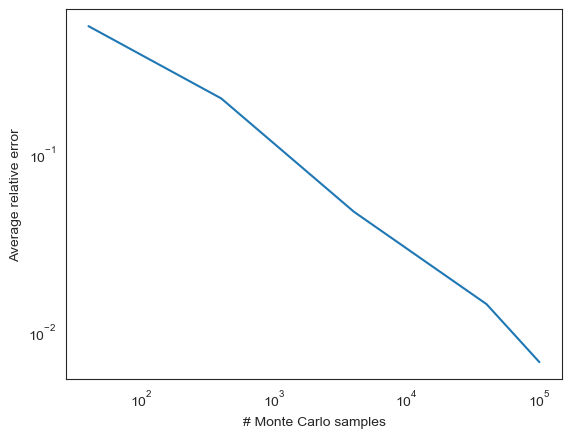

In [118]:
avg_relative_errors = [relative_errors[i].mean().item() for i in range(len(N_monte_carlo_grid))]
plt.plot(N_monte_carlo_grid, avg_relative_errors)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Average relative error")
plt.xlabel("# Monte Carlo samples")

In [111]:
((actual_correction[-1] - monte_correction[-1]) / actual_correction[-1]).abs().mean()

tensor(0.2390, grad_fn=<MeanBackward0>)

In [113]:
avg_relative_errors

[1.6604838371276855, 0.6229236721992493, 0.23899392783641815]

In [114]:
relative_errors[-1].mean()

tensor(0.2390, grad_fn=<MeanBackward0>)

(array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   2., 260., 235.]),
 array([-12.01593304, -10.67163467,  -9.32733727,  -7.9830389 ,
         -6.63874054,  -5.29444265,  -3.95014453,  -2.60584641,
         -1.2615484 ,   0.08274965,   1.42704773]),
 <BarContainer object of 10 artists>)

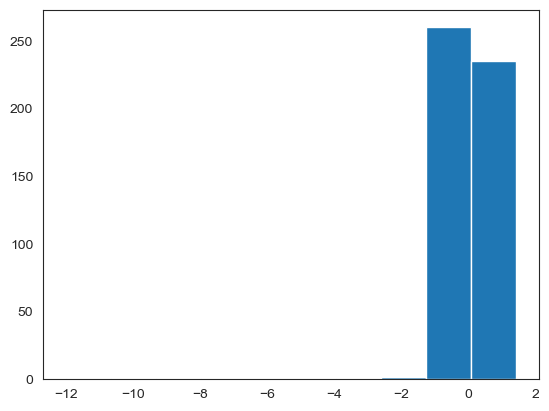

In [115]:
plt.hist(signed_relative_errors[-1].detach().numpy())

Text(0.5, 0, 'Monte Carlo EIF correction')

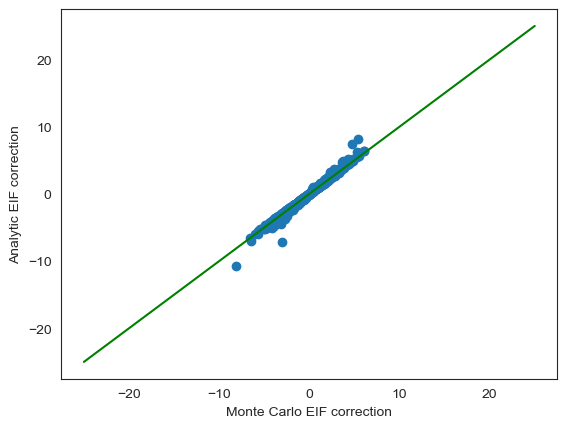

In [99]:
plt.scatter(monte_correction[-1].detach().numpy(), actual_correction[-1].detach().numpy())
plt.plot(np.linspace(-25, 25), np.linspace(-25, 25), c="g")
plt.ylabel("Analytic EIF correction")
plt.xlabel("Monte Carlo EIF correction")

Text(0.5, 0, 'Monte Carlo EIF correction')

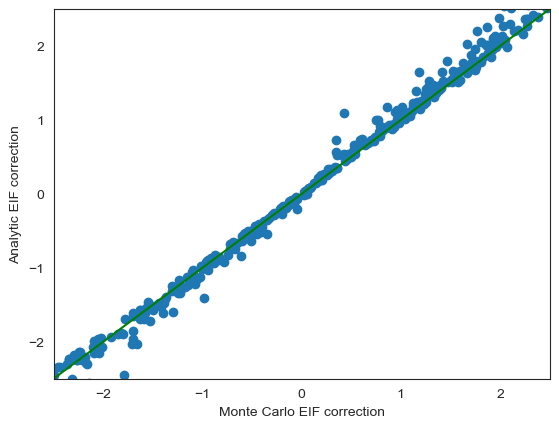

In [100]:
import numpy as np
plt.scatter(monte_correction[-1].detach().numpy(), actual_correction[-1].detach().numpy())
plt.plot(np.linspace(-2.5, 2.5), np.linspace(-2.5, 2.5), c="g")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.ylabel("Analytic EIF correction")
plt.xlabel("Monte Carlo EIF correction")

In [92]:
analytic_eif_at_test_pts

tensor([-6.1970e-01,  2.1919e+00,  2.0182e+00,  3.5666e-01,  2.1330e+00,
        -1.6840e+00,  4.1893e+00, -5.3721e+00,  2.4404e+00,  2.4825e+00,
        -1.7566e+00,  3.1887e+00, -1.6653e+00,  2.4356e+00,  3.2646e+00,
         4.4570e+00,  2.2882e+00, -4.6358e+00,  3.0366e+00,  3.5780e+00,
        -5.0978e+00,  1.3714e+00,  1.6288e+00,  2.1080e-01, -4.8999e+00,
        -6.7896e-02,  6.3227e-01, -1.0541e-01,  3.9028e+00, -4.1070e+00,
         3.7177e+00,  1.0325e+01,  1.3316e-01, -4.5900e+00, -2.0897e+00,
         1.9309e+00, -4.7524e+00, -4.5755e+00, -4.4305e+00,  2.9849e+00,
         1.9417e+00, -5.1241e-01,  2.3280e+00,  9.4685e-01,  4.5406e-01,
        -4.2394e-01, -1.5405e-01, -2.6523e+00,  2.7484e+00,  6.2555e+00,
        -8.9985e-01, -6.1338e+00,  2.2679e+00, -1.3200e+00,  1.3948e+00,
        -2.6254e+00, -3.5453e+00, -2.5635e+00,  3.9207e+00,  6.8637e+00,
        -4.9014e+00, -5.1206e+00,  3.6133e+00,  3.9147e-03, -2.9498e-01,
         3.0627e-01, -1.2690e+00, -2.5648e+00, -9.6

In [28]:
relative_errors[-1]

tensor([3.9556e+00, 2.0237e+00, 2.3506e-01, 3.2986e+00, 1.5224e+00, 4.5712e-01,
        2.3770e-01, 2.1696e+00, 2.7424e+00, 5.6880e+00, 3.7345e+00, 8.3168e+00,
        5.0564e+00, 4.4976e+00, 8.0852e-01, 4.5640e+00, 1.6331e+00, 7.9876e+00,
        1.6260e+00, 2.5923e+00, 6.4860e-01, 6.4732e+00, 4.8193e+00, 1.2846e+00,
        1.3530e-01, 1.0990e-01, 2.9183e+00, 7.6483e-01, 2.2046e+00, 1.4221e+00,
        6.2292e-02, 4.0267e+00, 4.8607e-01, 3.6437e+00, 2.6771e+00, 1.3128e+00,
        1.9718e+00, 1.9679e+00, 5.7444e+00, 6.8076e+00, 2.8257e+00, 6.4087e+00,
        2.4232e+00, 2.6341e-02, 3.7946e+00, 5.1388e+01, 3.8842e+00, 2.1072e+00,
        9.9912e-01, 1.7566e+00, 3.0235e+00, 3.1146e-01, 8.6886e-01, 1.2175e-01,
        5.7683e+00, 1.3650e+00, 2.5836e+00, 1.2715e+00, 4.5797e+00, 7.5808e+00,
        5.5826e+00, 4.1740e+00, 2.4771e+00, 1.1978e+00, 7.9958e-01, 2.1766e+00,
        2.7995e-01, 7.2661e+00, 4.3056e-01, 1.7785e+00, 4.0348e-01, 2.6773e+00,
        6.4539e+00, 8.8618e+00, 2.1140e+

In [23]:
avg_relative_errors

[11.656283378601074,
 4.712959289550781,
 4.100194931030273,
 4.355804920196533,
 4.238893508911133,
 4.214924335479736]

In [15]:
1/torch.sqrt(torch.tensor(500))

tensor(0.0447)

In [20]:
((relative_errors[-2] - relative_errors[-1])).abs().mean()

tensor(0.0184, grad_fn=<MeanBackward0>)

# Empirical evaluation

In [6]:
# Since we have access to the true data-generating distribution, we
# can keep simulating new datasets and retraining the model to get the 
# sampling distribution of each estimator. In practice, one would need to 
# use bootstrapping to approximate the true sampling distribution.

N_runs = 1
plug_in_estimates = []
one_step_correction_monte_carlo = []
one_step_correction_analytic = []

p = 2
alpha = 2
beta = 2
N_train = 5
N_test = 3

link = bernoulli_link

for i in range(N_runs):
    pyro.clear_param_store()

    # Generate data
    benchmark_model = BenchmarkLinearModel(p, link, alpha, beta)

    with pyro.poutine.trace() as train_tr:
        benchmark_model(N=N_train)

    with pyro.poutine.trace() as test_tr:
        benchmark_model(N=N_test)

    D_train = {k: train_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}
    D_test = {k: test_tr.trace.nodes[k]["value"] for k in ["X", "A", "Y"]}


    print(f"Run {i}/{N_runs}")
    conditioned_model = ConditionedModel(p, link)
    guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo(D_train)

    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for step in range(2000):
        adam.zero_grad()
        loss = elbo(D_train)
        loss.backward()
        adam.step()
        # if step % 250 == 0:
        #     print("[iteration %04d] loss: %.4f" % (step, loss))
    theta_hat = {k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()}
    print(theta_hat.keys(), theta_hat["treatment_weight"])

    unconditioned_model = KnownCovariateDistModel(p, link)
    model_cond_theta = condition(data=theta_hat)(unconditioned_model)

    ATE_plugin = ATE(model_cond_theta, num_samples=10000)
    # print("ATE plugin", ATE_plugin)

    ATE_correction = one_step_correction(
        lambda m: ATE(m, num_samples=1000),
        unconditioned_model,
        conditioned_model,
        ["X", "A", "Y"],
        theta_hat,
        D_test,
        eps_fisher=0.0,
        N_monte_carlo=25*p
    )
    ATE_onestep = ATE_plugin + ATE_correction
    # print(ATE_plugin, ATE_correction, ATE_onestep)

    analytic_correction, analytic_eif_at_test_pts = closed_form_ate_correction(D_test, theta_hat)

    plug_in_estimates.append(ATE_plugin.item())
    one_step_correction_monte_carlo.append(ATE_correction.item())
    one_step_correction_analytic.append(analytic_correction.item())

plug_in_estimates = torch.tensor(plug_in_estimates)
one_step_correction_monte_carlo = torch.tensor(one_step_correction_monte_carlo)
one_step_correction_analytic = torch.tensor(one_step_correction_analytic)

Run 0/1


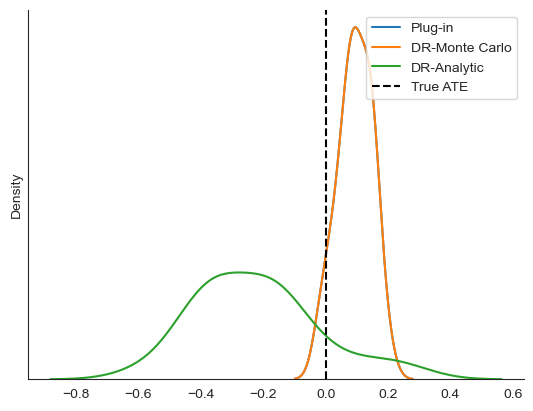

In [27]:
fig, ax = plt.subplots()

sns.kdeplot(
    plug_in_estimates, 
    label="Plug-in", ax=ax
)

sns.kdeplot(
    plug_in_estimates + one_step_correction_monte_carlo, 
    label="DR-Monte Carlo", ax=ax
)

sns.kdeplot(
    plug_in_estimates + one_step_correction_analytic, 
    label="DR-Analytic", ax=ax
)

ax.axvline(0, color="black", label="True ATE", linestyle="--")
ax.set_yticks([])
sns.despine()
ax.legend(loc="upper right")